### Import libraries

In [1]:
import warnings

import numpy as np
import pandas as pd
import random
import torch
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
import sys
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ["USE_OPENMP"] = '1'

sys.path.append(os.path.abspath("../"))
from fe_modules.aggregates import get_agg_count, get_agg_sum, get_top_n_mode, \
                                  get_agg_mean, get_agg_max, get_agg_min, \
                                  get_agg_median, get_agg_std, get_agg_nunique, \
                                  get_price_of_all_cpes, get_ratio_part_of_day
from fe_modules.cyclical_features import generate_cyclical_features
from fe_modules.datetime_features import get_year, get_month, get_day, \
                                         get_timestamp, get_day_of_year, \
                                         get_day_of_week, get_holiday_name, \
                                         part_of_day_to_hour, add_hour_to_date, \
                                         get_relative_time, mean_first_visit, \
                                         mean_last_visit
from fe_modules.encoders import TargetEncoderWrapper
from fe_modules.feature_merges import add_cat_features
from fe_modules.geo_features import map_cities, geo_dist, dist_to_large_cities, \
                                    map_grid, MapGridTransformer
from fe_modules.missing import map_prices
from fe_modules.preprocessing import clean_os_type
from fe_modules.text_manipulation import get_domain
from fe_modules.time_lags import generate_time_lags
from fe_modules.recsys_features import ALSWrapper, RecVAEWrapper

from fe_modules.user_fe import UserFE

from modules.memory_utils import pandas_reduce_mem_usage

In [3]:
def my_reset(*varnames):
    """
    varnames are what you want to keep
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset  # lets keep this function by default
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)

In [4]:
random_state = 69

random.seed(random_state),
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

### Read Data

In [5]:
LOCAL_DATA = "../data"

In [6]:
df = pandas_reduce_mem_usage(
    pd.read_parquet(f'../10m.parquet')
)

Memory usage of dataframe is 963.21 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 963.21 MB
Decreased by 0.0%


In [7]:
# df = pandas_reduce_mem_usage( 
#         pd.read_parquet(f'context_data/competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet')
# )
# df
df = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/competition_data_final_pqt')
)

targets = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/public_train.pqt')
) 

df = df.merge(targets, how="left", on="user_id")

df.head()

Memory usage of dataframe is 29562.33 MB


  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage after optimization is: 24943.21 MB
Decreased by 15.6%
Memory usage of dataframe is 8.24 MB


  0%|          | 0/3 [00:00<?, ?it/s]

Memory usage after optimization is: 6.18 MB
Decreased by 25.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN


In [7]:
df["is_male"] = df["is_male"].fillna(value=np.nan)
df.loc[df["is_male"] == "NA", "is_male"] = np.nan
df["is_male"] = df["is_male"].astype(np.float32)
df

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN


In [8]:
userfe = UserFE()
userfe.load_df(df)

Memory usage of dataframe is 0.38 MB


  0%|          | 0/7 [00:00<?, ?it/s]

Memory usage after optimization is: 0.38 MB
Decreased by 0.0%


### Feature Engineering

In [10]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [15]:
df = map_prices(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 29870.27 MB


  0%|          | 0/14 [00:00<?, ?it/s]

Memory usage after optimization is: 29870.27 MB
Decreased by 0.0%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964,57.0,0.0
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964,57.0,0.0
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964,57.0,0.0
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964,57.0,0.0


In [16]:
userfe.get_agg(df, target_col="price", agg_name="mean", alias="mean_price")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 22.18 MB


  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 22.18 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0


In [17]:
userfe.get_agg(df, target_col="url_host", agg_name="count", alias="actions_number")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 25.35 MB


  0%|          | 0/9 [00:00<?, ?it/s]

Memory usage after optimization is: 22.97 MB
Decreased by 9.4%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313


In [18]:
userfe.get_agg(df, target_col="date", agg_name="nunique", alias="nunique_date")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 26.14 MB


  0%|          | 0/10 [00:00<?, ?it/s]

Memory usage after optimization is: 23.76 MB
Decreased by 9.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15


In [19]:
userfe.get_agg(df, target_col="request_cnt", agg_name="sum", alias="request_sum")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 26.93 MB


  0%|          | 0/11 [00:00<?, ?it/s]

Memory usage after optimization is: 25.35 MB
Decreased by 5.9%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,request_sum
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,2261
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,1286
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,3306
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,2437
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,441


In [20]:
userfe.get_top_n_mode(df, target_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 42.78 MB


  0%|          | 0/16 [00:00<?, ?it/s]

Memory usage after optimization is: 42.78 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,2261,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,1286,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,3306,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,2437,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,441,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net


In [21]:
userfe.get_ratio(df, ratio_col="url_host", n=5)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 58.62 MB


  0%|          | 0/21 [00:00<?, ?it/s]

Memory usage after optimization is: 58.62 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,apple.com,i.ytimg.com,googleads.g.doubleclick.net,icloud.com,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,vk.com,sun9-27.userapi.com,sun9-32.userapi.com,ad.mail.ru,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923


In [22]:
userfe.get_ratio_part_of_day(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 71.29 MB


  0%|          | 0/25 [00:00<?, ?it/s]

Memory usage after optimization is: 64.96 MB
Decreased by 8.9%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_mode_4,url_host_ratio_0,url_host_ratio_1,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,morning,day,evening,night
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,avatars.mds.yandex.net,0.169032,0.148387,0.113548,0.108387,0.080645,0.254839,0.349677,0.287742,0.107742
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,sun9-5.userapi.com,0.084488,0.069252,0.067867,0.066482,0.059557,0.227147,0.412742,0.357341,0.002770
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,vk.com,0.102141,0.097859,0.088073,0.074006,0.051988,0.211621,0.358410,0.320489,0.109480
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,node1.online.sberbank.ru,0.145223,0.115287,0.084713,0.074522,0.067516,0.215287,0.350955,0.328025,0.105732
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,yastatic.net,0.079872,0.073482,0.057508,0.054313,0.047923,0.562300,0.207668,0.204473,0.025559


In [23]:
userfe.get_top_n_mode(df, target_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 74.46 MB


  0%|          | 0/28 [00:00<?, ?it/s]

Memory usage after optimization is: 74.46 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,url_host_ratio_2,url_host_ratio_3,url_host_ratio_4,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.113548,0.108387,0.080645,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.067867,0.066482,0.059557,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.088073,0.074006,0.051988,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.084713,0.074522,0.067516,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.057508,0.054313,0.047923,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>


In [24]:
userfe.get_ratio(df, ratio_col="region_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 83.97 MB


  0%|          | 0/31 [00:00<?, ?it/s]

Memory usage after optimization is: 83.97 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,morning,day,evening,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.254839,0.349677,0.287742,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.227147,0.412742,0.357341,0.002770,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.211621,0.358410,0.320489,0.109480,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.215287,0.350955,0.328025,0.105732,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.562300,0.207668,0.204473,0.025559,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0


In [25]:
userfe.get_top_n_mode(df, target_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 93.47 MB


  0%|          | 0/34 [00:00<?, ?it/s]

Memory usage after optimization is: 93.47 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,night,region_name_mode_0,region_name_mode_1,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.107742,Краснодарский край,Ставропольский край,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.002770,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.109480,Санкт-Петербург,Калининградская область,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.105732,Краснодарский край,<blank>,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.025559,Тюменская область,Свердловская область,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>


In [26]:
userfe.get_ratio(df, ratio_col="city_name", n=3)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 102.98 MB


  0%|          | 0/37 [00:00<?, ?it/s]

Memory usage after optimization is: 102.98 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_mode_2,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,Республика Адыгея,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,<blank>,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,<blank>,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,<blank>,1.0,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,<blank>,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0


In [27]:
userfe.get_agg(df, target_col="request_cnt", agg_name="mean", alias="mean_request_cnt")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 106.15 MB


  0%|          | 0/38 [00:00<?, ?it/s]

Memory usage after optimization is: 104.56 MB
Decreased by 1.5%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_ratio_0,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.995484,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.0,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.937615,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.0,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.99361,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946


In [9]:
df = part_of_day_to_hour(df)
df = add_hour_to_date(df)
df = get_timestamp(df)
# df = get_relative_time(df)
df = pandas_reduce_mem_usage(df)
df

Memory usage of dataframe is 1153.95 MB


  0%|          | 0/17 [00:00<?, ?it/s]

Memory usage after optimization is: 1115.80 MB
Decreased by 3.3%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,age,is_male,hour,datetime,timestamp
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-15 09:00:00,165528352.0
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098,NaN,NaN,0 days 09:00:00,2022-06-19 09:00:00,165562912.0
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098,NaN,NaN,0 days 15:00:00,2022-06-12 15:00:00,165504608.0
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-16 15:00:00,165271328.0
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098,NaN,NaN,0 days 15:00:00,2022-05-30 15:00:00,165392288.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999995,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,googleads.g.doubleclick.net,smartphone,Android,12544.0,2021-06-30,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-30 03:00:00,162502208.0
9999996,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-10,day,1,23799,NaN,NaN,0 days 15:00:00,2021-07-10 15:00:00,162592928.0
9999997,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,vk.com,smartphone,Android,12544.0,2021-07-31,night,1,23799,NaN,NaN,0 days 03:00:00,2021-07-31 03:00:00,162770048.0
9999998,Ростовская область,Таганрог,Xiaomi,Redmi Note 8T,yandex.ru,smartphone,Android,12544.0,2021-06-26,night,1,23799,NaN,NaN,0 days 03:00:00,2021-06-26 03:00:00,162467648.0


In [30]:
userfe.get_timespan(df, date_col="datetime")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 107.73 MB


  0%|          | 0/39 [00:00<?, ?it/s]

Memory usage after optimization is: 106.15 MB
Decreased by 1.5%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,region_name_ratio_1,region_name_ratio_2,city_name_mode_0,city_name_mode_1,city_name_mode_2,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.003871,0.000645,Краснодар,Ставрополь,Адыгейск,0.995484,0.002581,0.000645,1.458710,10087200.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.0,0.0,Санкт-Петербург,<blank>,<blank>,1.0,0.0,0.0,1.781163,6177600.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.0,Санкт-Петербург,Калининград,<blank>,0.937615,0.062385,0.0,2.022018,4320000.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.0,0.0,Новороссийск,<blank>,<blank>,1.0,0.0,0.0,1.552229,10065600.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.00639,0.0,Тюмень,Екатеринбург,<blank>,0.99361,0.00639,0.0,1.408946,1512000.0


In [10]:
df = get_agg_max(df, target_col="datetime", alias="date_max")

In [32]:
userfe.get_lag_agg(df, target_col="request_cnt", weeks_number=8, agg_name="sum")
userfe.df.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,mean_request_cnt,timespan,lag_user_id_group_sum_0,lag_user_id_group_sum_1,lag_user_id_group_sum_2,lag_user_id_group_sum_3,lag_user_id_group_sum_4,lag_user_id_group_sum_5,lag_user_id_group_sum_6,lag_user_id_group_sum_7
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,1.458710,10087200.0,154.0,216.0,149.0,62.0,117.0,87.0,99.0,118.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.781163,6177600.0,25.0,30.0,120.0,415.0,330.0,47.0,0.0,6.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,2.022018,4320000.0,429.0,510.0,505.0,391.0,342.0,533.0,448.0,56.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.552229,10065600.0,47.0,34.0,28.0,100.0,127.0,206.0,64.0,137.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,1.408946,1512000.0,110.0,246.0,65.0,0.0,0.0,0.0,0.0,0.0


In [33]:
userfe.get_lag_agg(df, target_col="request_cnt", weeks_number=8, agg_name="mean")
userfe.df.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_sum_6,lag_user_id_group_sum_7,lag_user_id_group_mean_0,lag_user_id_group_mean_1,lag_user_id_group_mean_2,lag_user_id_group_mean_3,lag_user_id_group_mean_4,lag_user_id_group_mean_5,lag_user_id_group_mean_6,lag_user_id_group_mean_7
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,99.0,118.0,1.327586,1.278107,1.354545,1.265306,1.519481,1.242857,1.337838,1.404762
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.0,6.0,1.086957,1.111111,1.600000,1.921296,1.813187,1.468750,0.000000,1.500000
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,448.0,56.0,2.102941,2.031873,2.095436,1.785388,1.868852,2.175510,2.164251,1.696970
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,64.0,137.0,1.305556,1.214286,1.217391,1.298701,1.257426,1.634921,1.280000,1.556818
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.0,0.0,1.341463,1.481928,1.382979,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
userfe.get_lag_agg(df, target_col="url_host", weeks_number=8, agg_name="nunique")
userfe.df.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_mean_6,lag_user_id_group_mean_7,lag_user_id_group_nunique_0,lag_user_id_group_nunique_1,lag_user_id_group_nunique_2,lag_user_id_group_nunique_3,lag_user_id_group_nunique_4,lag_user_id_group_nunique_5,lag_user_id_group_nunique_6,lag_user_id_group_nunique_7
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,1.337838,1.404762,32.0,45.0,17.0,11.0,15.0,18.0,18.0,30.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.000000,1.500000,15.0,14.0,15.0,30.0,32.0,19.0,0.0,4.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,2.164251,1.696970,51.0,58.0,60.0,54.0,50.0,54.0,30.0,19.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.280000,1.556818,17.0,10.0,5.0,20.0,34.0,46.0,13.0,41.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.000000,0.000000,57.0,65.0,19.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userfe.get_lag_top_n_mode(df, target_col="url_host", n=4, weeks_number=4)
userfe.df.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,lag_user_id_mode_0_0,lag_user_id_mode_0_1,lag_user_id_mode_0_2,...,lag_user_id_mode_1_2,lag_user_id_mode_1_3,lag_user_id_mode_2_0,lag_user_id_mode_2_1,lag_user_id_mode_2_2,lag_user_id_mode_2_3,lag_user_id_mode_3_0,lag_user_id_mode_3_1,lag_user_id_mode_3_2,lag_user_id_mode_3_3
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,icloud.com,...,icloud.com,m.avito.ru,apple.com,avatars.mds.yandex.net,icloud.com,googleads.g.doubleclick.net,apple.com,googleads.g.doubleclick.net,i.ytimg.com,icloud.com
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,i.ytimg.com,vk.com,sun9-80.userapi.com,...,sun9-85.userapi.com,sun9-80.userapi.com,ad.mail.ru,unblock.mts.ru,vk.com,sun9-61.userapi.com,sun9-32.userapi.com,vk.com,sun9-29.userapi.com,sun9-17.userapi.com
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,yandex.ru,i.ytimg.com,googleads.g.doubleclick.net,...,yandex.ru,ad.mail.ru,i.ytimg.com,yandex.ru,ad.mail.ru,googleads.g.doubleclick.net,i.ytimg.com,yandex.ru,ad.mail.ru,googleads.g.doubleclick.net
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,...,yandex.ru,node1.online.sberbank.ru,i.ytimg.com,googleads.g.doubleclick.net,node1.online.sberbank.ru,online.sberbank.ru,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,node1.online.sberbank.ru
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,yastatic.net,avatars.mds.yandex.net,...,i.ytimg.com,ad.mail.ru,yandex.ru,avatars.mds.yandex.net,googleads.g.doubleclick.net,i.ytimg.com,NaN,NaN,NaN,NaN


In [13]:
userfe.get_lag_ratio_part_of_day(df, weeks_number=4)
userfe.df.head()

,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,lag_user_id_mode_0_0,lag_user_id_mode_0_1,lag_user_id_mode_0_2,...,evening_1,night_1,morning_2,day_2,evening_2,night_2,morning_3,day_3,evening_3,night_3
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,apple.com,i.ytimg.com,icloud.com,...,0.266272,0.059172,0.163636,0.427273,0.254545,0.154545,0.285714,0.346939,0.285714,0.081633
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,i.ytimg.com,vk.com,sun9-80.userapi.com,...,0.407407,0.000000,0.173333,0.546667,0.266667,0.013333,0.259259,0.425926,0.310185,0.004630
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,yandex.ru,i.ytimg.com,googleads.g.doubleclick.net,...,0.350598,0.111554,0.153527,0.336100,0.273859,0.236515,0.173516,0.360731,0.429224,0.036530
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,...,0.500000,0.000000,0.130435,0.565217,0.304348,0.000000,0.129870,0.467532,0.402597,0.000000
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,yandex.ru,yastatic.net,avatars.mds.yandex.net,...,0.168675,0.036145,0.340426,0.489362,0.170213,0.000000,NaN,NaN,NaN,NaN


In [35]:
userfe.get_ratio_request_timespan()
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 185.36 MB


  0%|          | 0/64 [00:00<?, ?it/s]

Memory usage after optimization is: 145.76 MB
Decreased by 21.4%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_mean_7,lag_user_id_group_nunique_0,lag_user_id_group_nunique_1,lag_user_id_group_nunique_2,lag_user_id_group_nunique_3,lag_user_id_group_nunique_4,lag_user_id_group_nunique_5,lag_user_id_group_nunique_6,lag_user_id_group_nunique_7,ratio_request_timespan
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,1.404762,32.0,45.0,17.0,11.0,15.0,18.0,18.0,30.0,0.000224
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.500000,15.0,14.0,15.0,30.0,32.0,19.0,0.0,4.0,0.000208
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,1.696970,51.0,58.0,60.0,54.0,50.0,54.0,30.0,19.0,0.000765
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.556818,17.0,10.0,5.0,20.0,34.0,46.0,13.0,41.0,0.000242
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.000000,57.0,65.0,19.0,0.0,0.0,0.0,0.0,0.0,0.000292


In [36]:
userfe.get_first_visit_sec(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 148.93 MB


  0%|          | 0/65 [00:00<?, ?it/s]

Memory usage after optimization is: 147.34 MB
Decreased by 1.1%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_nunique_0,lag_user_id_group_nunique_1,lag_user_id_group_nunique_2,lag_user_id_group_nunique_3,lag_user_id_group_nunique_4,lag_user_id_group_nunique_5,lag_user_id_group_nunique_6,lag_user_id_group_nunique_7,ratio_request_timespan,first_visit_sec
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,32.0,45.0,17.0,11.0,15.0,18.0,18.0,30.0,0.000224,16455852.0
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,15.0,14.0,15.0,30.0,32.0,19.0,0.0,4.0,0.000208,16238340.0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,51.0,58.0,60.0,54.0,50.0,54.0,30.0,19.0,0.000765,16293636.0
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,17.0,10.0,5.0,20.0,34.0,46.0,13.0,41.0,0.000242,16455852.0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,57.0,65.0,19.0,0.0,0.0,0.0,0.0,0.0,0.000292,16243524.0


In [37]:
userfe.get_agg(df, target_col="region_name", agg_name="nunique", alias="nunique_region_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 150.51 MB


  0%|          | 0/66 [00:00<?, ?it/s]

Memory usage after optimization is: 147.74 MB
Decreased by 1.8%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_nunique_1,lag_user_id_group_nunique_2,lag_user_id_group_nunique_3,lag_user_id_group_nunique_4,lag_user_id_group_nunique_5,lag_user_id_group_nunique_6,lag_user_id_group_nunique_7,ratio_request_timespan,first_visit_sec,nunique_region_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,45.0,17.0,11.0,15.0,18.0,18.0,30.0,0.000224,16455852.0,3
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,14.0,15.0,30.0,32.0,19.0,0.0,4.0,0.000208,16238340.0,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,58.0,60.0,54.0,50.0,54.0,30.0,19.0,0.000765,16293636.0,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,10.0,5.0,20.0,34.0,46.0,13.0,41.0,0.000242,16455852.0,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,65.0,19.0,0.0,0.0,0.0,0.0,0.0,0.000292,16243524.0,2


In [38]:
userfe.get_agg(df, target_col="city_name", agg_name="nunique", alias="nunique_city_name")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 150.91 MB


  0%|          | 0/67 [00:00<?, ?it/s]

Memory usage after optimization is: 148.13 MB
Decreased by 1.8%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,lag_user_id_group_nunique_2,lag_user_id_group_nunique_3,lag_user_id_group_nunique_4,lag_user_id_group_nunique_5,lag_user_id_group_nunique_6,lag_user_id_group_nunique_7,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,17.0,11.0,15.0,18.0,18.0,30.0,0.000224,16455852.0,3,5
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,15.0,30.0,32.0,19.0,0.0,4.0,0.000208,16238340.0,1,1
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,60.0,54.0,50.0,54.0,30.0,19.0,0.000765,16293636.0,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,5.0,20.0,34.0,46.0,13.0,41.0,0.000242,16455852.0,1,1
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,19.0,0.0,0.0,0.0,0.0,0.0,0.000292,16243524.0,2,2


In [39]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [40]:
FE_DATA = "../fe_data/"

In [ ]:
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_BEFORE_GEO_v1.parquet.gzip",
              compression='gzip')

df.to_parquet(f"{FE_DATA}/DF_BEFORE_GEO_v1.parquet.gzip",
              compression='gzip')

In [ ]:
df = pandas_reduce_mem_usage(pd.read_parquet(f"{FE_DATA}/DF_BEFORE_GEO_v1.parquet.gzip"))
userfe = UserFE()
userfe.load(f"{FE_DATA}/USER_FE_BEFORE_GEO_v1.parquet.gzip")
userfe.df.head()

In [ ]:
df = map_cities(df)
df = pandas_reduce_mem_usage(df)
df.head()

In [8]:
userfe.get_agg_amount_of_travel(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

Memory usage of dataframe is 127.54 MB


  0%|          | 0/44 [00:00<?, ?it/s]

Memory usage after optimization is: 125.16 MB
Decreased by 1.9%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_0,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.995484,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,1.000000,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.937615,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.000000,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.993610,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3


In [9]:
my_reset("df", "userfe")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
userfe.get_agg_distance_of_travel(df)
userfe.pandas_reduce_mem_usage()
userfe.df.head()

100%|██████████████████████████████████| 415317/415317 [13:34<00:00, 509.70it/s]


Memory usage of dataframe is 126.74 MB


  0%|          | 0/45 [00:00<?, ?it/s]

Memory usage after optimization is: 126.74 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel,user_id_mean_travel_distance
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8,229.241241
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0,0.000000
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2,1209.396484
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0,0.000000
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3,547.953491


In [5]:
FE_DATA = "../fe_data/"

In [16]:
userfe.df.to_parquet(f"{FE_DATA}/USER_FE_BEFORE_ALS.parquet.gzip",
              compression='gzip')

df.to_parquet(f"{FE_DATA}/DF_BEFORE_ALS.parquet.gzip",
              compression='gzip')

In [6]:
df = pandas_reduce_mem_usage(pd.read_parquet(f"{FE_DATA}/DF_BEFORE_ALS.parquet.gzip"))
userfe = UserFE()
userfe.load(f"{FE_DATA}/USER_FE_BEFORE_ALS.parquet.gzip")
userfe.df.head()

Memory usage of dataframe is 49555.79 MB


  0%|          | 0/22 [00:00<?, ?it/s]

Memory usage after optimization is: 49555.79 MB
Decreased by 0.0%
Memory usage of dataframe is 126.74 MB


  0%|          | 0/45 [00:00<?, ?it/s]

Memory usage after optimization is: 126.74 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,city_name_ratio_1,city_name_ratio_2,mean_request_cnt,timespan,ratio_request_timespan,first_visit_sec,nunique_region_name,nunique_city_name,user_id_amount_of_travel,user_id_mean_travel_distance
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.002581,0.000645,1.458710,100872.0,0.022415,16455852.0,3,5,8,229.241241
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.000000,0.000000,1.781163,61776.0,0.020817,16238340.0,1,1,0,0.000000
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.062385,0.000000,2.022018,43200.0,0.076528,16293636.0,2,2,2,1209.396484
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.000000,0.000000,1.552229,100656.0,0.024211,16455852.0,1,1,0,0.000000
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.006390,0.000000,1.408946,15120.0,0.029167,16243524.0,2,2,3,547.953491


In [7]:
# top_20k_url_host = pd.DataFrame(df["url_host"].value_counts())\
# .rename_axis('unique_url_host')\
# .reset_index()\
# .rename(columns={"url_host": "counts", "unique_url_host": "url_host"})

# top_20k_url_host

,url_host,counts
0,googleads.g.doubleclick.net,22441565
1,yandex.ru,19360163
2,i.ytimg.com,17228611
3,vk.com,17019343
4,avatars.mds.yandex.net,16496475
...,...,...
199678,trampoline.ru,1
199679,piterforyou.narod.ru,1
199680,ipfund.ru,1
199681,xn----8sbwhdycfgriq6h.xn--p1ai,1


In [8]:
# df = df.merge(top_20k_url_host, on="url_host", how="left")
# df = df[df["counts"] > 60]
# df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,...,is_male,hour,datetime,timestamp,capital_marker,timezone,geo_lat,geo_lon,population,counts
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,...,NaN,0 days 09:00:00,2022-06-15 09:00:00,165528360.0,2.0,3,45.04016,38.975965,744933,3586363
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,...,NaN,0 days 09:00:00,2022-06-19 09:00:00,165562920.0,2.0,3,45.04016,38.975965,744933,9902188
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,...,NaN,0 days 15:00:00,2022-06-12 15:00:00,165504600.0,2.0,3,45.04016,38.975965,744933,16496475
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,...,NaN,0 days 15:00:00,2022-05-16 15:00:00,165271320.0,2.0,3,45.04016,38.975965,744933,22441565
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,...,NaN,0 days 15:00:00,2022-05-30 15:00:00,165392280.0,2.0,3,45.04016,38.975965,744933,22441565


In [ ]:
# recvae = RecVAEWrapper(hidden_dim=500, latent_dim=64, random_state=42)
# recvae.fit(df, rows="user_id", columns="url_host", target="request_cnt", agg_fn="sum")

# usr_emb = recvae.get_embeddings(emb_name="recvae_emb_url_request_sum")
# userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
# userfe.pandas_reduce_mem_usage()
# userfe.df.head()

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

In [10]:
als = ALSWrapper(factors=86, iterations=60, regularization=1, alpha=3.0, use_gpu=False, random_state=42)
als.fit(df, rows="user_id", columns="url_host", target="request_cnt", agg_fn="sum")  # Можно еще попробовать agg_fn="count"
usr_emb = als.get_embeddings(emb_name="als_emb_url_request_sum")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Memory usage of dataframe is 263.00 MB


  0%|          | 0/131 [00:00<?, ?it/s]

Memory usage after optimization is: 263.00 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,als_emb_url_request_sum_76,als_emb_url_request_sum_77,als_emb_url_request_sum_78,als_emb_url_request_sum_79,als_emb_url_request_sum_80,als_emb_url_request_sum_81,als_emb_url_request_sum_82,als_emb_url_request_sum_83,als_emb_url_request_sum_84,als_emb_url_request_sum_85
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,0.896437,-0.274869,0.353650,-0.244079,-0.260690,0.323714,0.337329,0.567946,0.407322,-0.234517
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.795158,0.086613,0.141728,0.215061,-0.273353,0.500009,-0.230356,0.029084,0.433780,-0.070376
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,0.085076,0.582886,0.584696,0.067853,-0.430491,-0.399860,-0.122071,0.115347,0.924105,-0.165201
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,0.391612,0.149112,0.803544,0.382750,0.100827,0.157363,-0.199727,0.183474,0.308069,0.182700
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.315736,-0.053443,0.268095,0.155930,-0.195999,0.012825,0.071172,0.160969,0.132160,0.250107


In [11]:
als = ALSWrapper(factors=12, iterations=60, regularization=1, alpha=3.0, use_gpu=False, random_state=42)
als.fit(df, rows="user_id", columns="url_host", target="date", agg_fn="count")
usr_emb = als.get_embeddings(emb_name="als_emb_url_date_count")
userfe.df = userfe.df.merge(usr_emb, how="left", on="user_id")
userfe.pandas_reduce_mem_usage()
userfe.df.head()

  0%|          | 0/60 [00:00<?, ?it/s]

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,als_emb_url_date_count_2,als_emb_url_date_count_3,als_emb_url_date_count_4,als_emb_url_date_count_5,als_emb_url_date_count_6,als_emb_url_date_count_7,als_emb_url_date_count_8,als_emb_url_date_count_9,als_emb_url_date_count_10,als_emb_url_date_count_11
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,1.365983,-0.817326,1.095676,-1.049308,1.011595,-0.298115,1.310350,-0.519770,0.141200,-0.188585
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,0.562123,-0.400649,0.799547,-0.871641,1.141514,-0.309037,1.341361,0.081343,-0.417695,0.325033
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,1.489839,-0.827969,-0.095935,-0.978459,1.588498,0.160944,0.711642,-1.058200,-0.784221,0.115943
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,1.494483,-0.955169,0.300471,-0.885953,1.256678,0.065397,0.384441,-1.624638,-0.366316,0.344758
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,0.407198,-1.604325,0.433933,-0.948851,0.905053,0.185710,0.208515,-0.943200,-0.391241,-0.215550


In [12]:
FE_DATA = "../fe_data/"

userfe.df.to_parquet(f"{FE_DATA}/USER_FE.parquet.gzip",
              compression='gzip')

# CatBoost

In [5]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance

from catboost_modules.metrics import AGE_METRIC
from seq2seq_modules.utils import numpy_age_bucket

In [6]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE.parquet.gzip")

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


In [7]:
age_kicked = ["cpe_type_cd", "cpe_model_os_type", "region_name_mode_1", "region_name_mode_2", "region_name_ratio_0", "region_name_ratio_1", "city_name_mode_2", "city_name_ratio_0", "city_name_ratio_1", "nunique_region_name", "nunique_city_name"]
df_age = userfe.df[userfe.df["age"].notna()].drop(columns=["is_male"] + age_kicked)
df_age["age"] = numpy_age_bucket(df_age["age"])

#### Add seq2seq features

In [8]:
# age_cv_logits = pandas_reduce_mem_usage(
#     pd.read_parquet("../cv_data/age_cv_logits.parquet.gzip")
# ).drop(columns=["age"])

# age_cv_logits.head()

In [9]:
# from sklearn.decomposition import TruncatedSVD

# N_COMPONENTS = 128

# svd = TruncatedSVD(n_components=N_COMPONENTS, algorithm="arpack", random_state=42)
# svd_age_cv_embeddings = pd.DataFrame(
#     svd.fit_transform(age_cv_embeddings.drop(columns=["user_id"]).to_numpy()), 
#     columns=[f"seq2seq_feature_{i}" for i in range(N_COMPONENTS)]
# )

# svd_age_cv_embeddings["user_id"] = age_cv_embeddings["user_id"]
# svd_age_cv_embeddings.head()

In [10]:
# df_age = df_age.merge(
#         age_cv_logits, on="user_id",how="left"
# )

# df_age.isnull().sum().sum()

In [11]:
df_age

,cpe_manufacturer_name,cpe_model_name,user_id,age,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,url_host_mode_1,...,als_emb_url_date_count_2,als_emb_url_date_count_3,als_emb_url_date_count_4,als_emb_url_date_count_5,als_emb_url_date_count_6,als_emb_url_date_count_7,als_emb_url_date_count_8,als_emb_url_date_count_9,als_emb_url_date_count_10,als_emb_url_date_count_11
2,Samsung,Galaxy S20+,79395,1,74259.000000,1635,51,3306,i.ytimg.com,yandex.ru,...,1.489839,-0.827969,-0.095935,-0.978459,1.588498,0.160944,0.711642,-1.058200,-0.784221,0.115943
3,Xiaomi,Poco X3 Pro,91294,1,23876.000000,1570,113,2437,i.ytimg.com,googleads.g.doubleclick.net,...,1.494483,-0.955169,0.300471,-0.885953,1.256678,0.065397,0.384441,-1.624638,-0.366316,0.344758
4,Xiaomi,Redmi Note 8 Pro,161323,2,20465.000000,313,15,441,yandex.ru,googleads.g.doubleclick.net,...,0.407198,-1.604325,0.433933,-0.948851,0.905053,0.185710,0.208515,-0.943200,-0.391241,-0.215550
5,Huawei,Honor 10,304574,1,27701.000000,127,10,198,yandex.ru,googleads.g.doubleclick.net,...,0.081180,-0.851257,0.543621,-0.487769,1.095320,-0.138618,0.897259,-0.188956,-0.268108,-0.181143
8,Samsung,Galaxy A40 Dual,16874,1,14704.821853,1684,80,2849,googleads.g.doubleclick.net,yandex.ru,...,2.117665,-1.019793,1.026312,-0.400719,0.759769,0.338904,0.694476,-1.415971,-0.364267,0.300153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415309,Apple,iPhone 12,403319,1,82078.000000,58,3,92,icloud.com,ads.adfox.ru,...,0.014711,-0.631068,0.815290,-0.452130,1.284688,0.111502,0.430056,-0.201735,-0.140044,-0.287410
415311,Huawei,Honor 10,74976,2,19284.000000,779,51,1197,yandex.ru,googleads.g.doubleclick.net,...,0.811645,-1.344100,-0.074142,-1.039185,0.931007,-0.219450,1.365691,-0.387512,-0.105973,-0.360134
415312,Apple,iPhone X,375972,3,56357.000000,690,61,836,googleads.g.doubleclick.net,instagram.com,...,0.918823,-0.838173,1.099146,-1.065831,0.970116,0.051775,1.265041,-0.334548,-0.529178,-0.065464
415314,Huawei,P Smart Z,5505,1,15490.000000,96,11,124,vk.com,i.ytimg.com,...,0.150779,-0.570173,0.882696,-0.395248,0.945655,-0.440653,1.005762,0.282720,-0.294142,-0.147970


#### Age classification training

In [12]:
def coss_val_score(model, df, target_feature, metric, n_folds=5, random_state=42, calculate_importance=True):
    y = df[target_feature]
    users = df['user_id']
    X = df.drop(columns=[target_feature, 'user_id'])
    
    scores = []
    models = []
    
    importances = pd.DataFrame({"Feature Id": X.columns, 
                                "Importance": np.zeros(X.columns.shape[0]), 
                                "std": np.zeros(X.columns.shape[0])})
    
    skf = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    for i, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        train_dataset = Pool(X_train, y_train, cat_features=np.where(X.dtypes == object)[0])
        val_dataset = Pool(X_val, y_val, cat_features=np.where(X.dtypes == object)[0])
        
        model.fit(train_dataset,
                  eval_set=val_dataset, 
                  use_best_model=True)
        models.append(model)
        
        if target_feature == "age":
            preds = model.predict(val_dataset)
        elif target_feature == "is_male":
            preds = model.predict_proba(val_dataset)
        
        score = metric(preds, y_val)
        scores.append(list(score.values())[0])
        print(f"Fold {i}: {score}")
        
        if calculate_importance:
            r = permutation_importance(model, 
                                       X_val, 
                                       y_val,
                                       n_repeats=10,
                                       random_state=42)
        
        
            importances["Importance"] += r.importances_mean
            importances["std"] += r.importances_std
        
#         for i in r.importances_mean.argsort()[::-1]:
#             print(f"{X_val.columns[i]}")
#             print(f"{r.importances_mean[i]}")
            

    importances["Importance"] /= n_folds      
    importances["std"] /= n_folds      
    importances["good"] = importances["Importance"] - 2 * importances["std"] > 0
    
    return (models, (sum(scores) / n_folds), importances, X.columns)

In [13]:
params = {"loss_function": "MultiClass",
          "eval_metric": "TotalF1:average=Weighted",
          "verbose": 100,
          "iterations": 4000,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 100,
          "use_best_model": True,
         }

model_age = CatBoostClassifier(**params)

In [14]:
age_models, scores, age_importances, features = coss_val_score(model=model_age, df=df_age, target_feature="age", metric=AGE_METRIC, calculate_importance=False)

print(scores)

Learning rate set to 0.098744
0:	learn: 0.3357504	test: 0.3353771	best: 0.3353771 (0)	total: 9.9ms	remaining: 39.6s
100:	learn: 0.4133534	test: 0.4037146	best: 0.4037146 (100)	total: 665ms	remaining: 25.7s
200:	learn: 0.4379648	test: 0.4191725	best: 0.4191725 (200)	total: 1.29s	remaining: 24.5s
300:	learn: 0.4536712	test: 0.4250272	best: 0.4252880 (299)	total: 1.92s	remaining: 23.6s
400:	learn: 0.4659474	test: 0.4290360	best: 0.4290360 (400)	total: 2.56s	remaining: 23s
500:	learn: 0.4755371	test: 0.4305950	best: 0.4305950 (500)	total: 3.21s	remaining: 22.4s
600:	learn: 0.4849148	test: 0.4314782	best: 0.4315072 (582)	total: 3.84s	remaining: 21.7s
700:	learn: 0.4930075	test: 0.4334271	best: 0.4334271 (700)	total: 4.5s	remaining: 21.2s
800:	learn: 0.5014908	test: 0.4351499	best: 0.4352763 (798)	total: 5.15s	remaining: 20.6s
900:	learn: 0.5101689	test: 0.4357748	best: 0.4363430 (887)	total: 5.8s	remaining: 19.9s
1000:	learn: 0.5175980	test: 0.4359724	best: 0.4365435 (959)	total: 6.47s	rema

0.4330333087613495 - 64

0.4335037722889773 - 86

0.43512080570535755 - als по 60 эпох

0.4362427870174205 - regularization = 0.5

0.43987563156945936 - alpha = 2.0

0.441532668664951 - top sites > 60

In [15]:
age_importances["good"].sum(), age_importances["good"].sum() / age_importances.shape[0]

(0, 0.0)

In [25]:
for i, model in enumerate(age_models):
    model.save_model(f"../catboost_models/age_v2/cb_age_v2_{i}")

In [23]:
fi = pd.DataFrame(data={
    "Feature Id": age_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importance": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in age_models])
})
fi

,Feature Id,Importance
175,actions_number,0.431517
12,als_emb_url_date_count_0,8.206066
22,als_emb_url_date_count_1,5.567967
33,als_emb_url_date_count_10,4.437458
14,als_emb_url_date_count_11,8.030229
...,...,...
114,url_host_ratio_2,1.315362
144,url_host_ratio_3,0.793837
100,url_host_ratio_4,1.637713
153,user_id_amount_of_travel,0.749719


Text(0.5, 1.0, 'CatBoost Feature Importance')

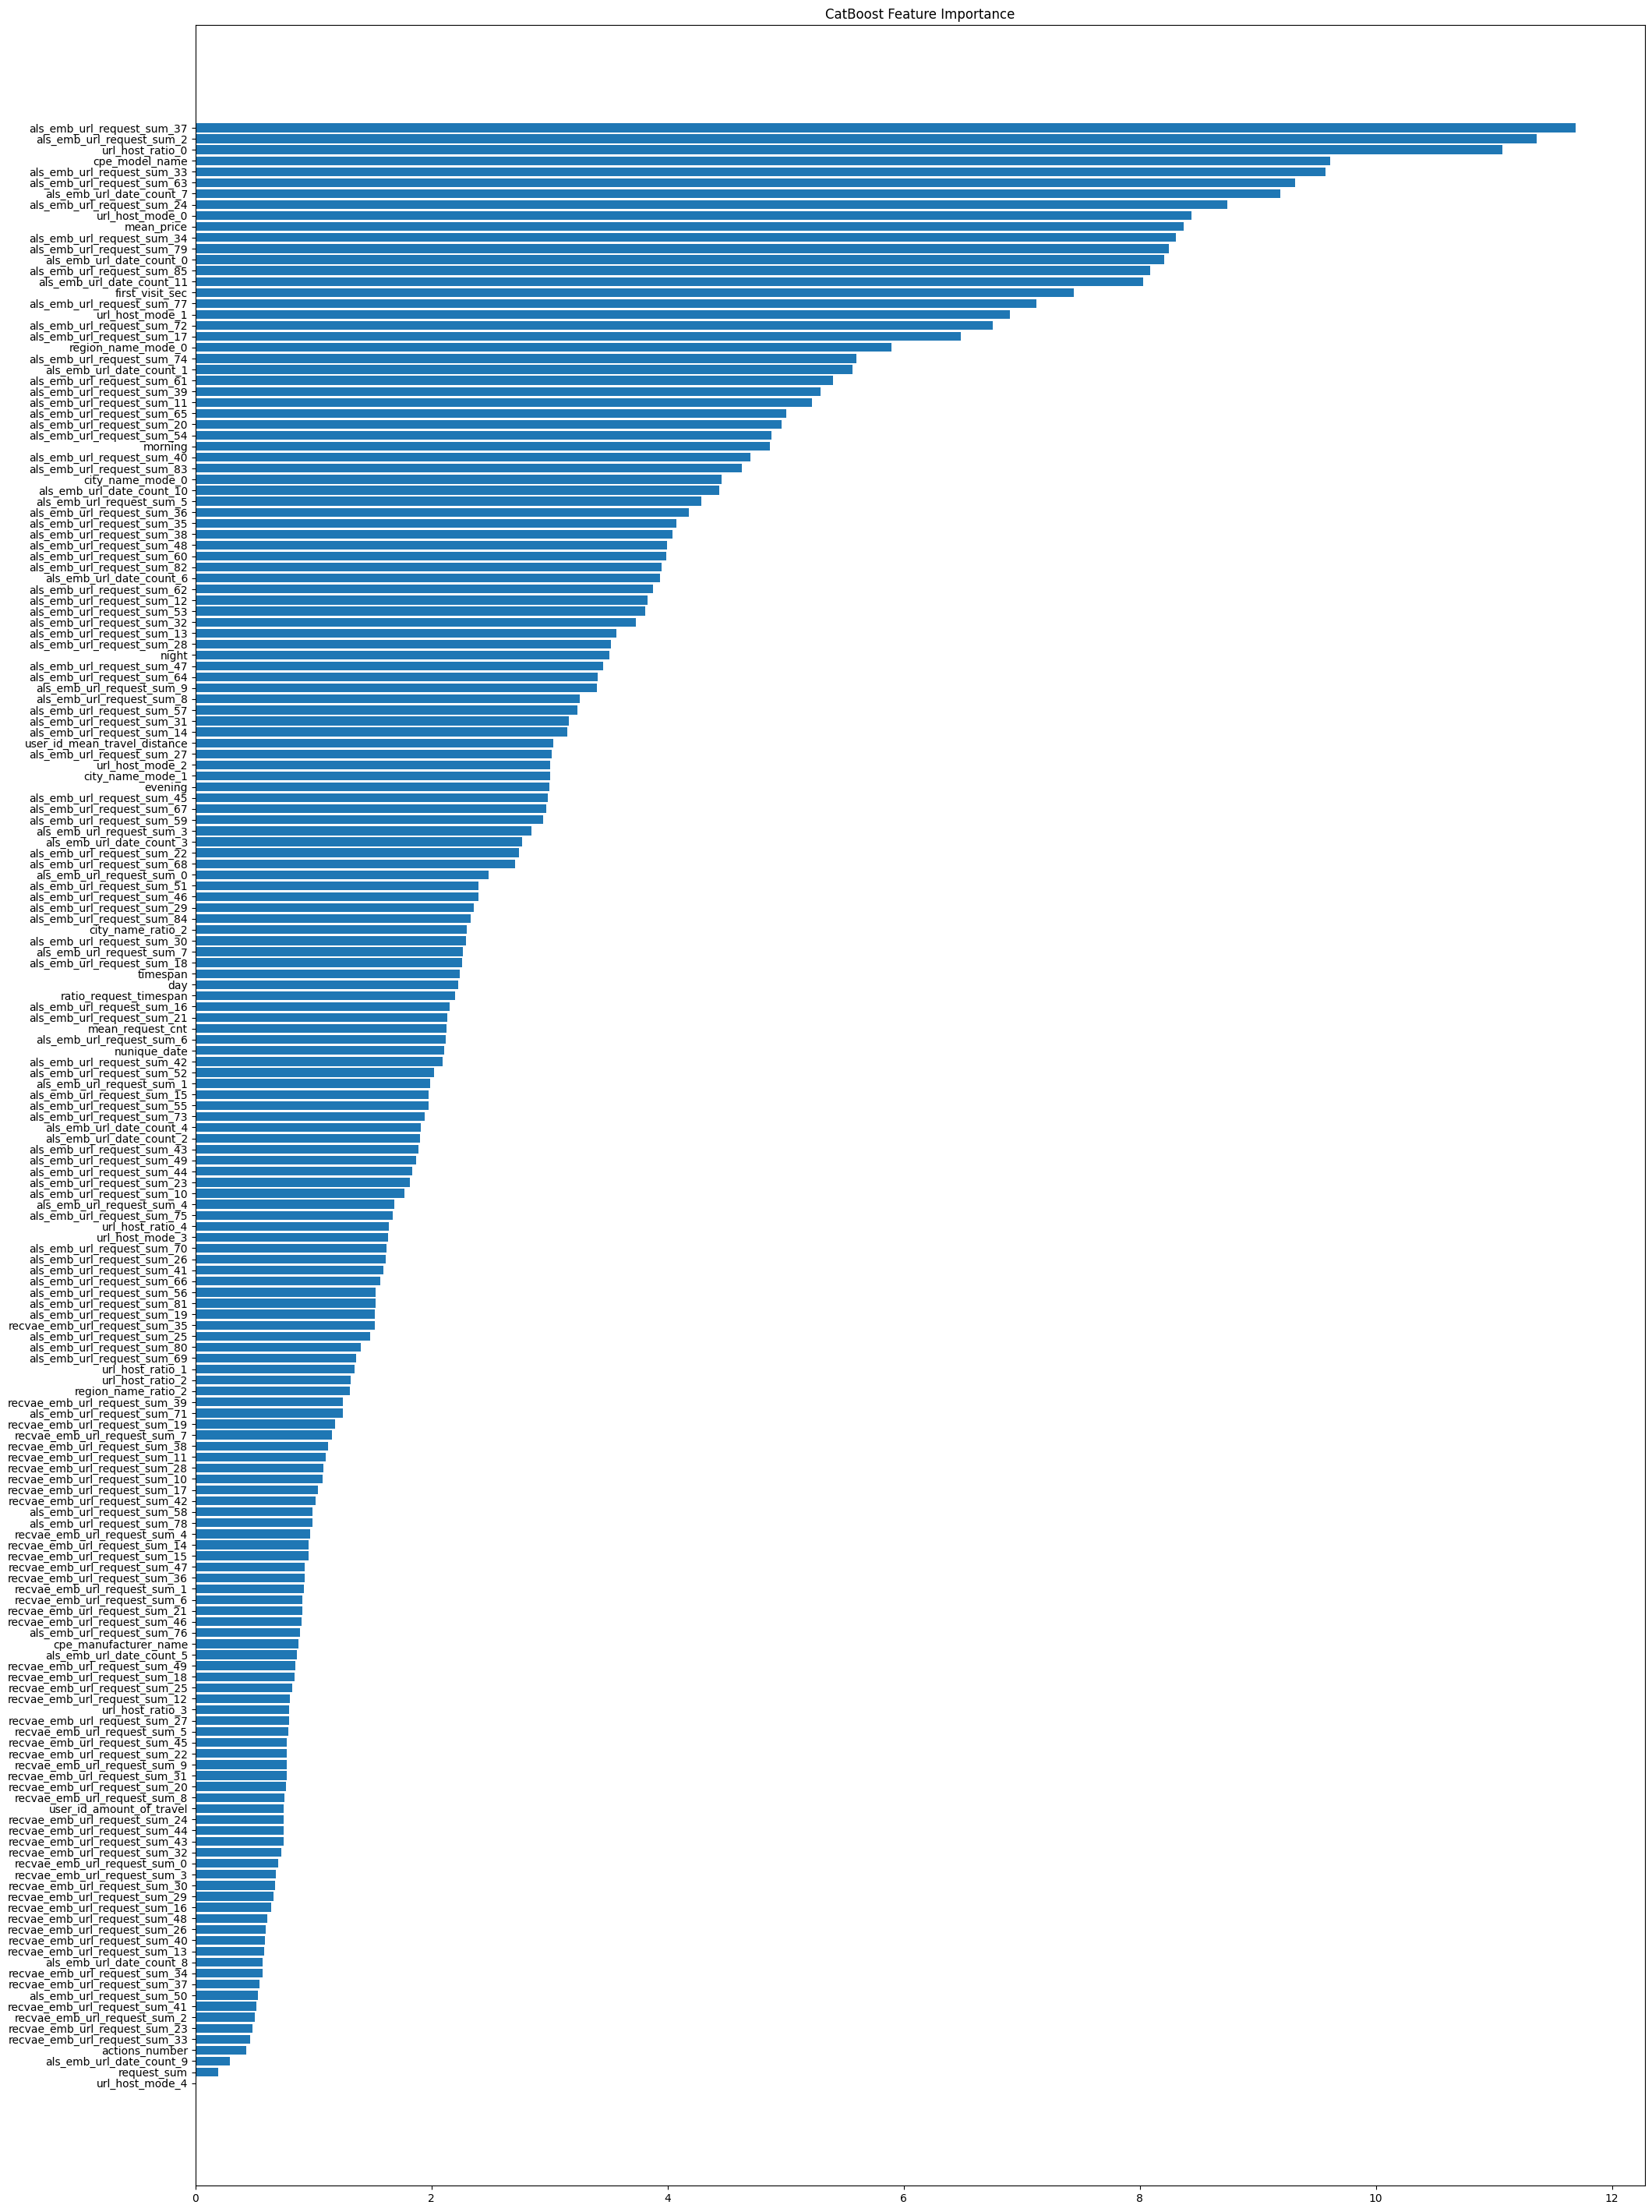

In [24]:
feature_importance = fi["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('CatBoost Feature Importance')

In [14]:
age_importances[~age_importances["good"]]

,Feature Id,Importance,std,good
0,cpe_manufacturer_name,0.0,0.0,False
1,cpe_model_name,0.0,0.0,False
2,mean_price,0.0,0.0,False
3,actions_number,0.0,0.0,False
4,nunique_date,0.0,0.0,False
...,...,...,...,...
124,emb_url_date_count_7,0.0,0.0,False
125,emb_url_date_count_8,0.0,0.0,False
126,emb_url_date_count_9,0.0,0.0,False
127,emb_url_date_count_10,0.0,0.0,False


In [15]:
age_kicked = ["cpe_type_cd", "cpe_model_os_type", "region_name_mode_1", "region_name_mode_2", "region_name_ratio_0", "region_name_ratio_1", "city_name_mode_2", "city_name_ratio_0", "city_name_ratio_1", "nunique_region_name", "nunique_city_name"]

Text(0.5, 1.0, 'Permutation Feature Importance')

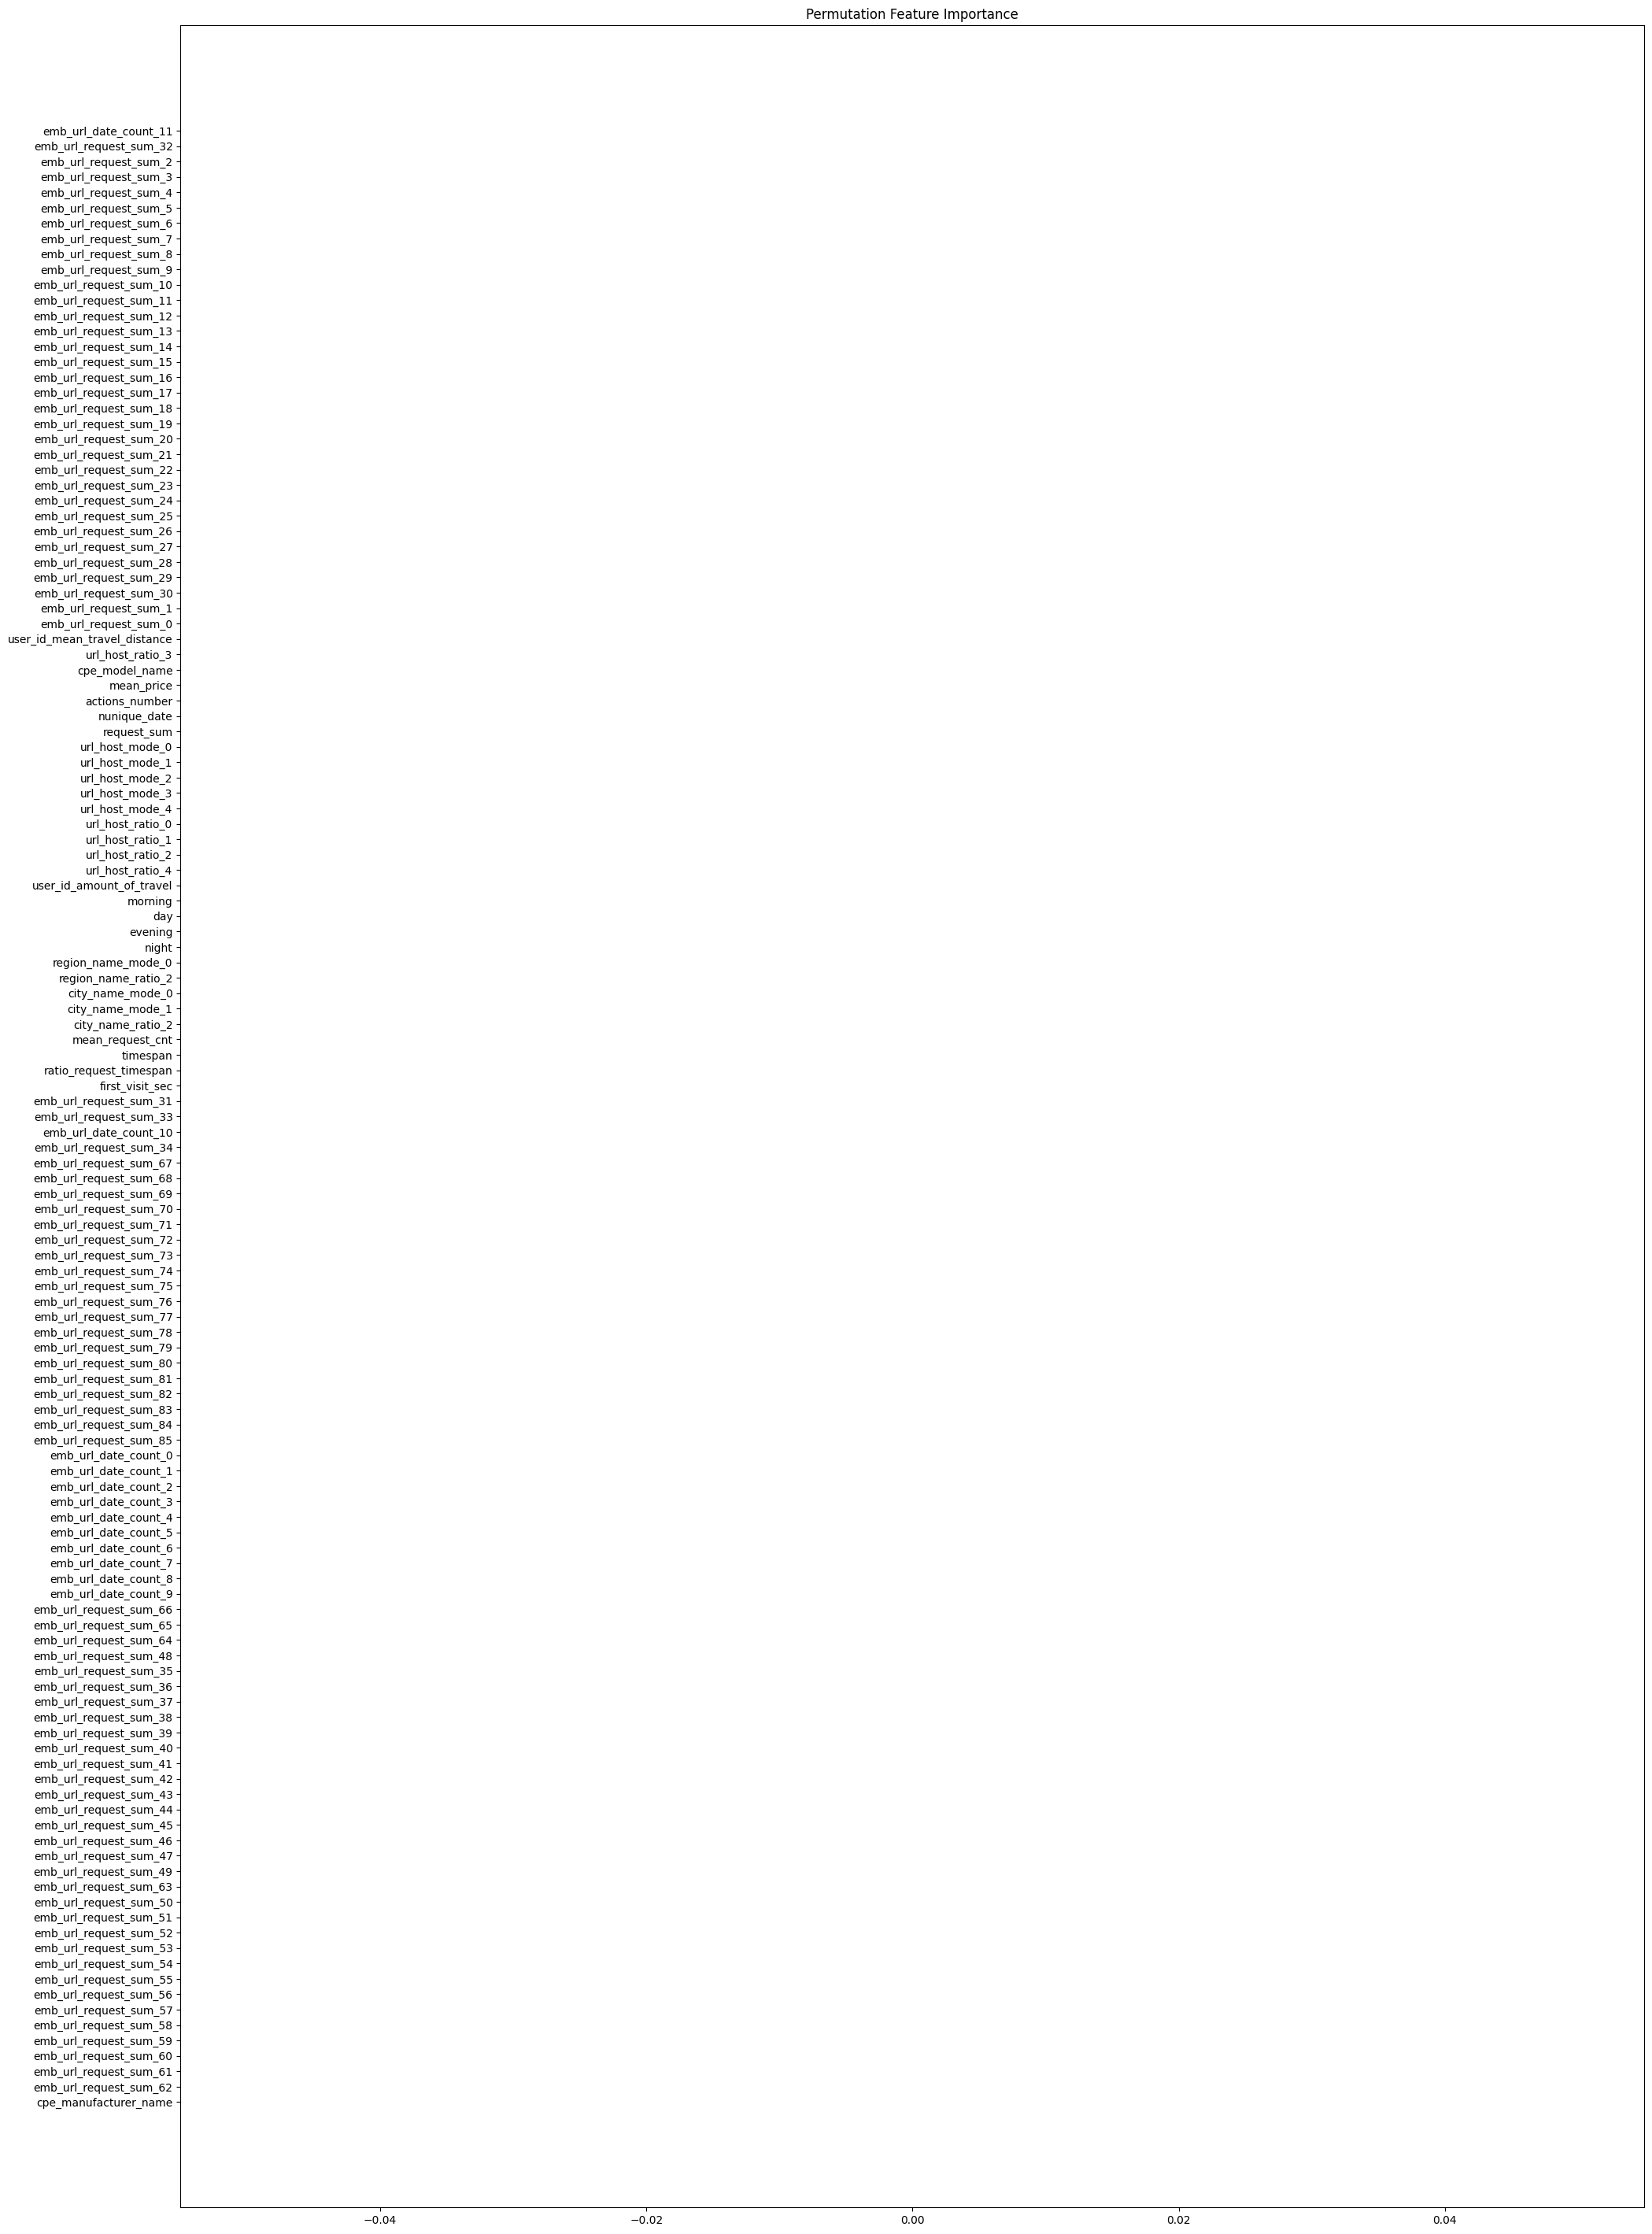

In [16]:
feature_importance = age_importances["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), age_importances["Feature Id"].to_numpy()[sorted_idx])
plt.title('Permutation Feature Importance')

#### is_ male classification training

In [16]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from sklearn.model_selection import train_test_split

from catboost_modules.metrics import GENDER_METRIC

In [17]:
is_male_kicked = ["cpe_manufacturer_name", "cpe_type_cd", "cpe_model_os_type", "nunique_date", "actions_number", "request_sum", "url_host_mode_4", "url_host_ratio_1", "url_host_ratio_2", "url_host_ratio_3", "url_host_ratio_4"]
df_is_male = userfe.df[userfe.df["is_male"].notna()].drop(columns=["age"] + is_male_kicked)
df_is_male.head()

,cpe_model_name,user_id,is_male,mean_price,url_host_mode_0,url_host_mode_1,url_host_mode_2,url_host_mode_3,url_host_ratio_0,morning,...,als_emb_url_date_count_2,als_emb_url_date_count_3,als_emb_url_date_count_4,als_emb_url_date_count_5,als_emb_url_date_count_6,als_emb_url_date_count_7,als_emb_url_date_count_8,als_emb_url_date_count_9,als_emb_url_date_count_10,als_emb_url_date_count_11
2,Galaxy S20+,79395,1.0,74259.000000,i.ytimg.com,yandex.ru,googleads.g.doubleclick.net,ad.mail.ru,0.102141,0.211621,...,0.046168,0.604464,-0.078456,0.710180,-0.436829,0.352948,0.950727,-2.413761,-1.230357,0.360891
3,Poco X3 Pro,91294,1.0,23876.000000,i.ytimg.com,googleads.g.doubleclick.net,yandex.ru,online.sberbank.ru,0.145223,0.215287,...,0.291475,0.582710,-0.250085,0.938873,-0.486661,0.936658,1.394228,-1.876460,-1.336544,0.398932
4,Redmi Note 8 Pro,161323,0.0,20465.000000,yandex.ru,googleads.g.doubleclick.net,i.ytimg.com,avatars.mds.yandex.net,0.079872,0.562300,...,0.363369,0.686622,-0.797887,0.479450,-0.434968,0.734555,0.009212,-1.940067,-0.557483,0.185938
5,Honor 10,304574,1.0,27701.000000,yandex.ru,googleads.g.doubleclick.net,avatars.mds.yandex.net,i.ytimg.com,0.165354,0.196850,...,0.023657,0.427395,-0.496464,0.505055,-0.256891,0.656976,-0.307134,-0.966994,-0.428204,0.672597
8,Galaxy A40 Dual,16874,0.0,14704.821853,googleads.g.doubleclick.net,yandex.ru,yastatic.net,avatars.mds.yandex.net,0.089074,0.266627,...,0.409850,1.346241,-0.233869,1.837701,-0.463615,0.334696,1.661842,-2.073118,-0.910219,0.243810


In [18]:
# is_male_cv_embeddings = pandas_reduce_mem_usage(
#     pd.read_parquet("../cv_data/is_male_cv_embeddings.parquet.gzip")
# ).drop(columns=["is_male"])

# is_male_cv_logits = pandas_reduce_mem_usage(
#     pd.read_parquet("../cv_data/is_male_cv_logits.parquet.gzip")
# ).drop(columns=["is_male", "target_feature_0"])

# is_male_cv_logits.head()

In [19]:
# df_is_male = df_is_male.merge(
#         is_male_cv_logits, on="user_id",how="left"
# )
# # .merge(
# #         is_male_cv_logits, on="user_id",how="left"
# # )
# df_is_male.isnull().sum().sum()

In [20]:
params = {"loss_function": "Logloss",
          "eval_metric": "NormalizedGini",
          "verbose": 100,
          "iterations": 2000,
#           "max_depth": 10,
          "random_state": 42,
          "task_type": "GPU" if get_gpu_device_count() else "CPU",
          "early_stopping_rounds": 200,
          "use_best_model": True,
         }

model_is_male = CatBoostClassifier(**params)

In [21]:
is_male_models, scores, is_male_importances, features = coss_val_score(model=model_is_male, df=df_is_male, target_feature="is_male", metric=GENDER_METRIC, calculate_importance=False)

print(scores)

Learning rate set to 0.033904


Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4097988	best: 0.4097988 (0)	total: 19.8ms	remaining: 39.6s
100:	test: 0.6186453	best: 0.6186453 (100)	total: 1.96s	remaining: 36.8s
200:	test: 0.6519274	best: 0.6519274 (200)	total: 3.91s	remaining: 35s
300:	test: 0.6667490	best: 0.6667490 (300)	total: 5.85s	remaining: 33s
400:	test: 0.6759492	best: 0.6759492 (400)	total: 7.78s	remaining: 31s
500:	test: 0.6826156	best: 0.6826232 (499)	total: 9.7s	remaining: 29s
600:	test: 0.6873433	best: 0.6873433 (600)	total: 11.6s	remaining: 27.1s
700:	test: 0.6911193	best: 0.6911193 (700)	total: 13.6s	remaining: 25.2s
800:	test: 0.6943612	best: 0.6943612 (800)	total: 15.5s	remaining: 23.3s
900:	test: 0.6968144	best: 0.6968144 (900)	total: 17.5s	remaining: 21.4s
1000:	test: 0.6988639	best: 0.6988639 (1000)	total: 19.5s	remaining: 19.4s
1100:	test: 0.7007712	best: 0.7007712 (1100)	total: 21.4s	remaining: 17.5s
1200:	test: 0.7024221	best: 0.7024272 (1199)	total: 23.4s	remaining: 15.5s
1300:	test: 0.7038639	best: 0.7038639 (1300)	total: 25.3s

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4141259	best: 0.4141259 (0)	total: 19.9ms	remaining: 39.8s
100:	test: 0.6177473	best: 0.6177473 (100)	total: 1.96s	remaining: 36.9s
200:	test: 0.6502757	best: 0.6502757 (200)	total: 3.88s	remaining: 34.8s
300:	test: 0.6639392	best: 0.6639392 (300)	total: 5.82s	remaining: 32.8s
400:	test: 0.6731738	best: 0.6731738 (400)	total: 7.76s	remaining: 30.9s
500:	test: 0.6796311	best: 0.6796311 (500)	total: 9.7s	remaining: 29s
600:	test: 0.6846606	best: 0.6846606 (600)	total: 11.6s	remaining: 27.1s
700:	test: 0.6884018	best: 0.6884018 (700)	total: 13.6s	remaining: 25.2s
800:	test: 0.6914692	best: 0.6914692 (800)	total: 15.5s	remaining: 23.3s
900:	test: 0.6940503	best: 0.6940503 (900)	total: 17.5s	remaining: 21.3s
1000:	test: 0.6964397	best: 0.6964397 (1000)	total: 19.3s	remaining: 19.3s
1100:	test: 0.6983164	best: 0.6983164 (1100)	total: 21.3s	remaining: 17.4s
1200:	test: 0.7000887	best: 0.7000887 (1200)	total: 23.2s	remaining: 15.4s
1300:	test: 0.7014294	best: 0.7014294 (1300)	total:

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4116585	best: 0.4116585 (0)	total: 20.2ms	remaining: 40.3s
100:	test: 0.6261496	best: 0.6261496 (100)	total: 2.1s	remaining: 39.6s
200:	test: 0.6586771	best: 0.6586771 (200)	total: 4.12s	remaining: 36.9s
300:	test: 0.6729058	best: 0.6729058 (300)	total: 6.18s	remaining: 34.9s
400:	test: 0.6821188	best: 0.6821188 (400)	total: 8.23s	remaining: 32.8s
500:	test: 0.6886103	best: 0.6886103 (500)	total: 10.2s	remaining: 30.6s
600:	test: 0.6933391	best: 0.6933391 (600)	total: 12.2s	remaining: 28.5s
700:	test: 0.6971411	best: 0.6971411 (700)	total: 14.3s	remaining: 26.4s
800:	test: 0.7001082	best: 0.7001082 (800)	total: 16.3s	remaining: 24.4s
900:	test: 0.7026315	best: 0.7026315 (900)	total: 18.4s	remaining: 22.4s
1000:	test: 0.7047735	best: 0.7047735 (1000)	total: 20.4s	remaining: 20.3s
1100:	test: 0.7065156	best: 0.7065156 (1100)	total: 22.4s	remaining: 18.3s
1200:	test: 0.7080226	best: 0.7080226 (1200)	total: 24.4s	remaining: 16.3s
1300:	test: 0.7094104	best: 0.7094104 (1300)	tota

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4061081	best: 0.4061081 (0)	total: 19ms	remaining: 38.1s
100:	test: 0.6243185	best: 0.6243185 (100)	total: 1.96s	remaining: 36.9s
200:	test: 0.6562275	best: 0.6562275 (200)	total: 3.93s	remaining: 35.2s
300:	test: 0.6703959	best: 0.6703959 (300)	total: 5.95s	remaining: 33.6s
400:	test: 0.6795457	best: 0.6795457 (400)	total: 7.96s	remaining: 31.7s
500:	test: 0.6855664	best: 0.6855664 (500)	total: 9.94s	remaining: 29.8s
600:	test: 0.6902672	best: 0.6902672 (600)	total: 11.9s	remaining: 27.8s
700:	test: 0.6938385	best: 0.6938385 (700)	total: 13.9s	remaining: 25.8s
800:	test: 0.6966469	best: 0.6966469 (800)	total: 15.9s	remaining: 23.8s
900:	test: 0.6991118	best: 0.6991118 (900)	total: 17.9s	remaining: 21.8s
1000:	test: 0.7010613	best: 0.7010613 (1000)	total: 19.8s	remaining: 19.8s
1100:	test: 0.7027644	best: 0.7027644 (1100)	total: 21.8s	remaining: 17.8s
1200:	test: 0.7043183	best: 0.7043183 (1200)	total: 23.7s	remaining: 15.8s
1300:	test: 0.7058431	best: 0.7058434 (1299)	total

Default metric period is 5 because NormalizedGini is/are not implemented for GPU
Metric NormalizedGini is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.4077476	best: 0.4077476 (0)	total: 19.6ms	remaining: 39.1s
100:	test: 0.6240268	best: 0.6240268 (100)	total: 1.96s	remaining: 36.8s
200:	test: 0.6571835	best: 0.6571835 (200)	total: 3.93s	remaining: 35.2s
300:	test: 0.6725465	best: 0.6725465 (300)	total: 5.94s	remaining: 33.5s
400:	test: 0.6818009	best: 0.6818009 (400)	total: 7.89s	remaining: 31.5s
500:	test: 0.6880314	best: 0.6880314 (500)	total: 9.84s	remaining: 29.4s
600:	test: 0.6927283	best: 0.6927283 (600)	total: 11.8s	remaining: 27.5s
700:	test: 0.6965288	best: 0.6965288 (700)	total: 13.7s	remaining: 25.4s
800:	test: 0.6993411	best: 0.6993411 (800)	total: 15.7s	remaining: 23.4s
900:	test: 0.7019471	best: 0.7019471 (900)	total: 17.6s	remaining: 21.5s
1000:	test: 0.7040854	best: 0.7040890 (999)	total: 19.6s	remaining: 19.6s
1100:	test: 0.7059779	best: 0.7059779 (1100)	total: 21.6s	remaining: 17.6s
1200:	test: 0.7073646	best: 0.7073646 (1200)	total: 23.5s	remaining: 15.6s
1300:	test: 0.7087446	best: 0.7087446 (1300)	tota

0.7611993345854822 - seq2eq logits

In [24]:
for i, model in enumerate(is_male_models):
    model.save_model(f"../catboost_models/is_male_v2/cb_is_male_v2_{i}")

In [22]:
fi = pd.DataFrame(data={
    "Feature Id": is_male_models[0].get_feature_importance(prettified=True).sort_values("Feature Id")["Feature Id"],
    "Importamce": sum([model.get_feature_importance(prettified=True).sort_values("Feature Id")["Importances"].to_numpy().flatten() for model in is_male_models])
})
fi

,Feature Id,Importamce
86,city_name_mode_0,1.428252
80,city_name_mode_1,1.616416
126,city_name_mode_2,0.597690
109,city_name_ratio_0,0.937955
76,city_name_ratio_1,1.763636
...,...,...
57,url_host_mode_2,2.198857
67,url_host_mode_3,1.973144
23,url_host_ratio_0,3.843949
11,user_id_amount_of_travel,4.772249


Text(0.5, 1.0, 'Feature Importance')

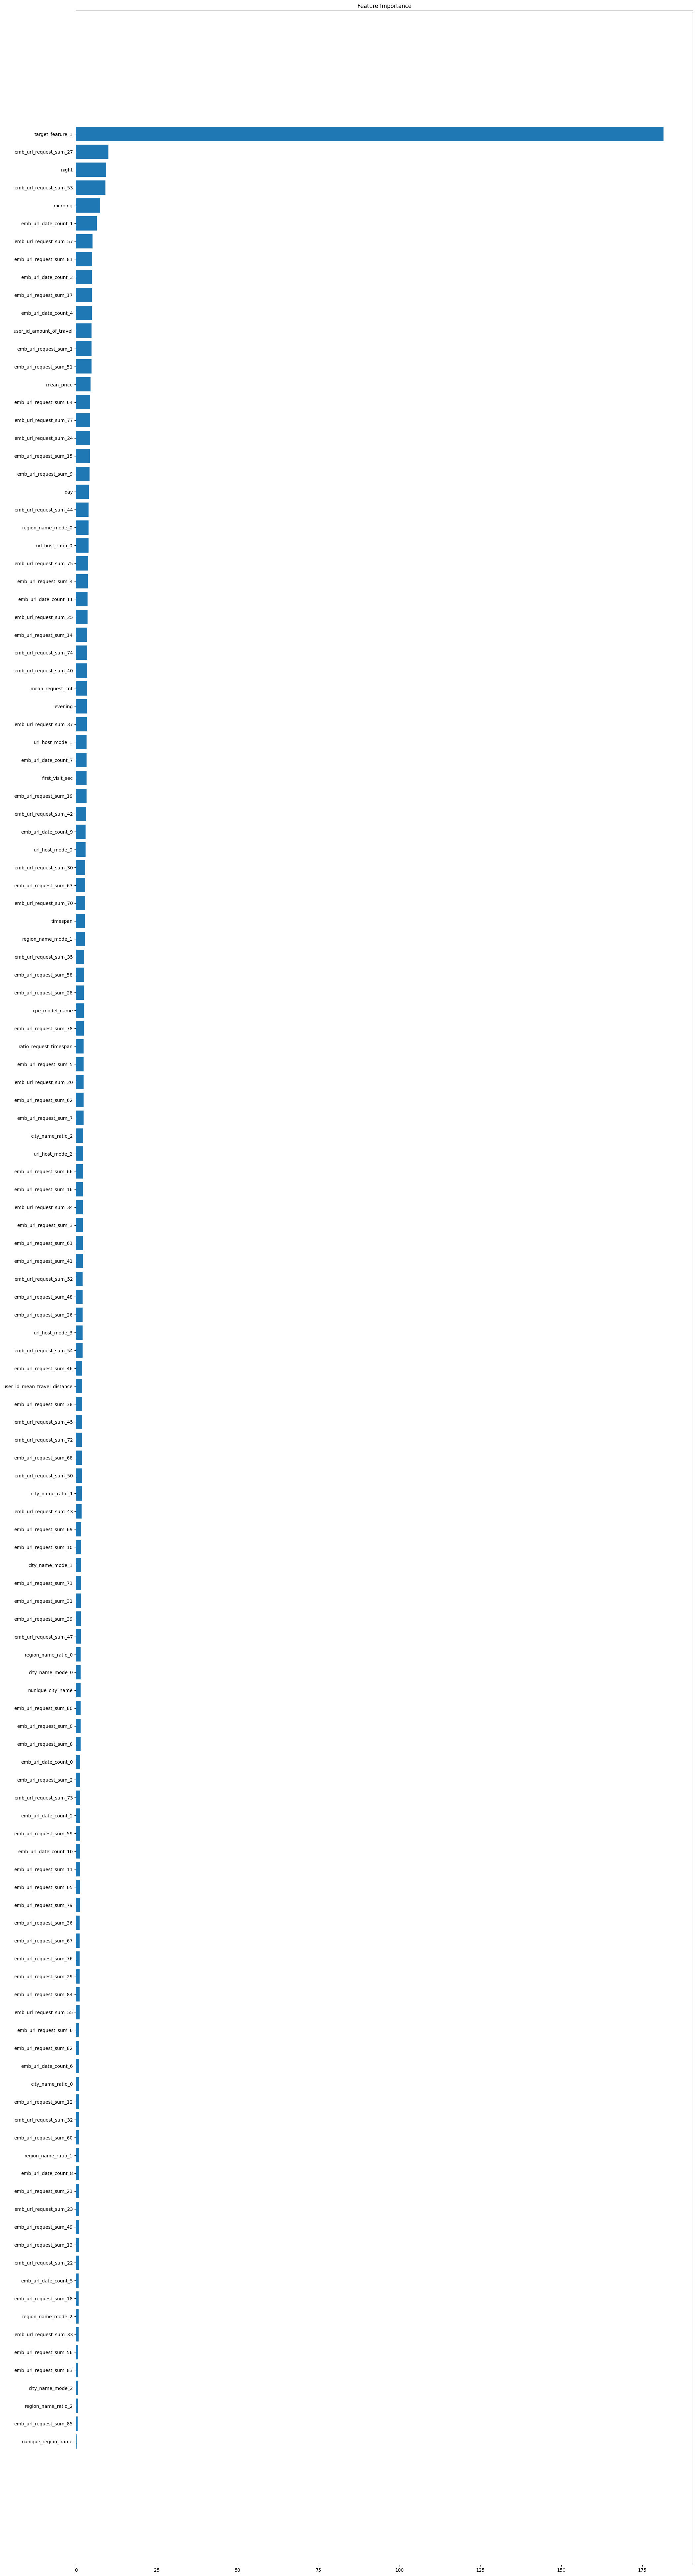

In [23]:
feature_importance = fi["Importamce"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 100))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), fi["Feature Id"].to_numpy()[sorted_idx])
plt.title('Feature Importance')

In [64]:
is_male_importances["good"].sum(), is_male_importances["good"].sum() / is_male_importances.shape[0]

(58, 0.4142857142857143)

In [68]:
is_male_importances[~is_male_importances["good"]].head(90)

,Feature Id,Importance,std,good
0,cpe_manufacturer_name,0.000112,0.000234,False
2,cpe_type_cd,-0.000002,0.000013,False
3,cpe_model_os_type,-0.000007,0.000050,False
4,mean_price,0.000204,0.000291,False
5,actions_number,0.000048,0.000212,False
...,...,...,...,...
125,emb_url_request_sum_83,0.000017,0.000141,False
126,emb_url_request_sum_84,0.000582,0.000380,False
127,emb_url_request_sum_85,0.000079,0.000173,False
134,emb_url_date_count_6,0.001074,0.000541,False


Text(0.5, 1.0, 'Permutation Feature Importance')

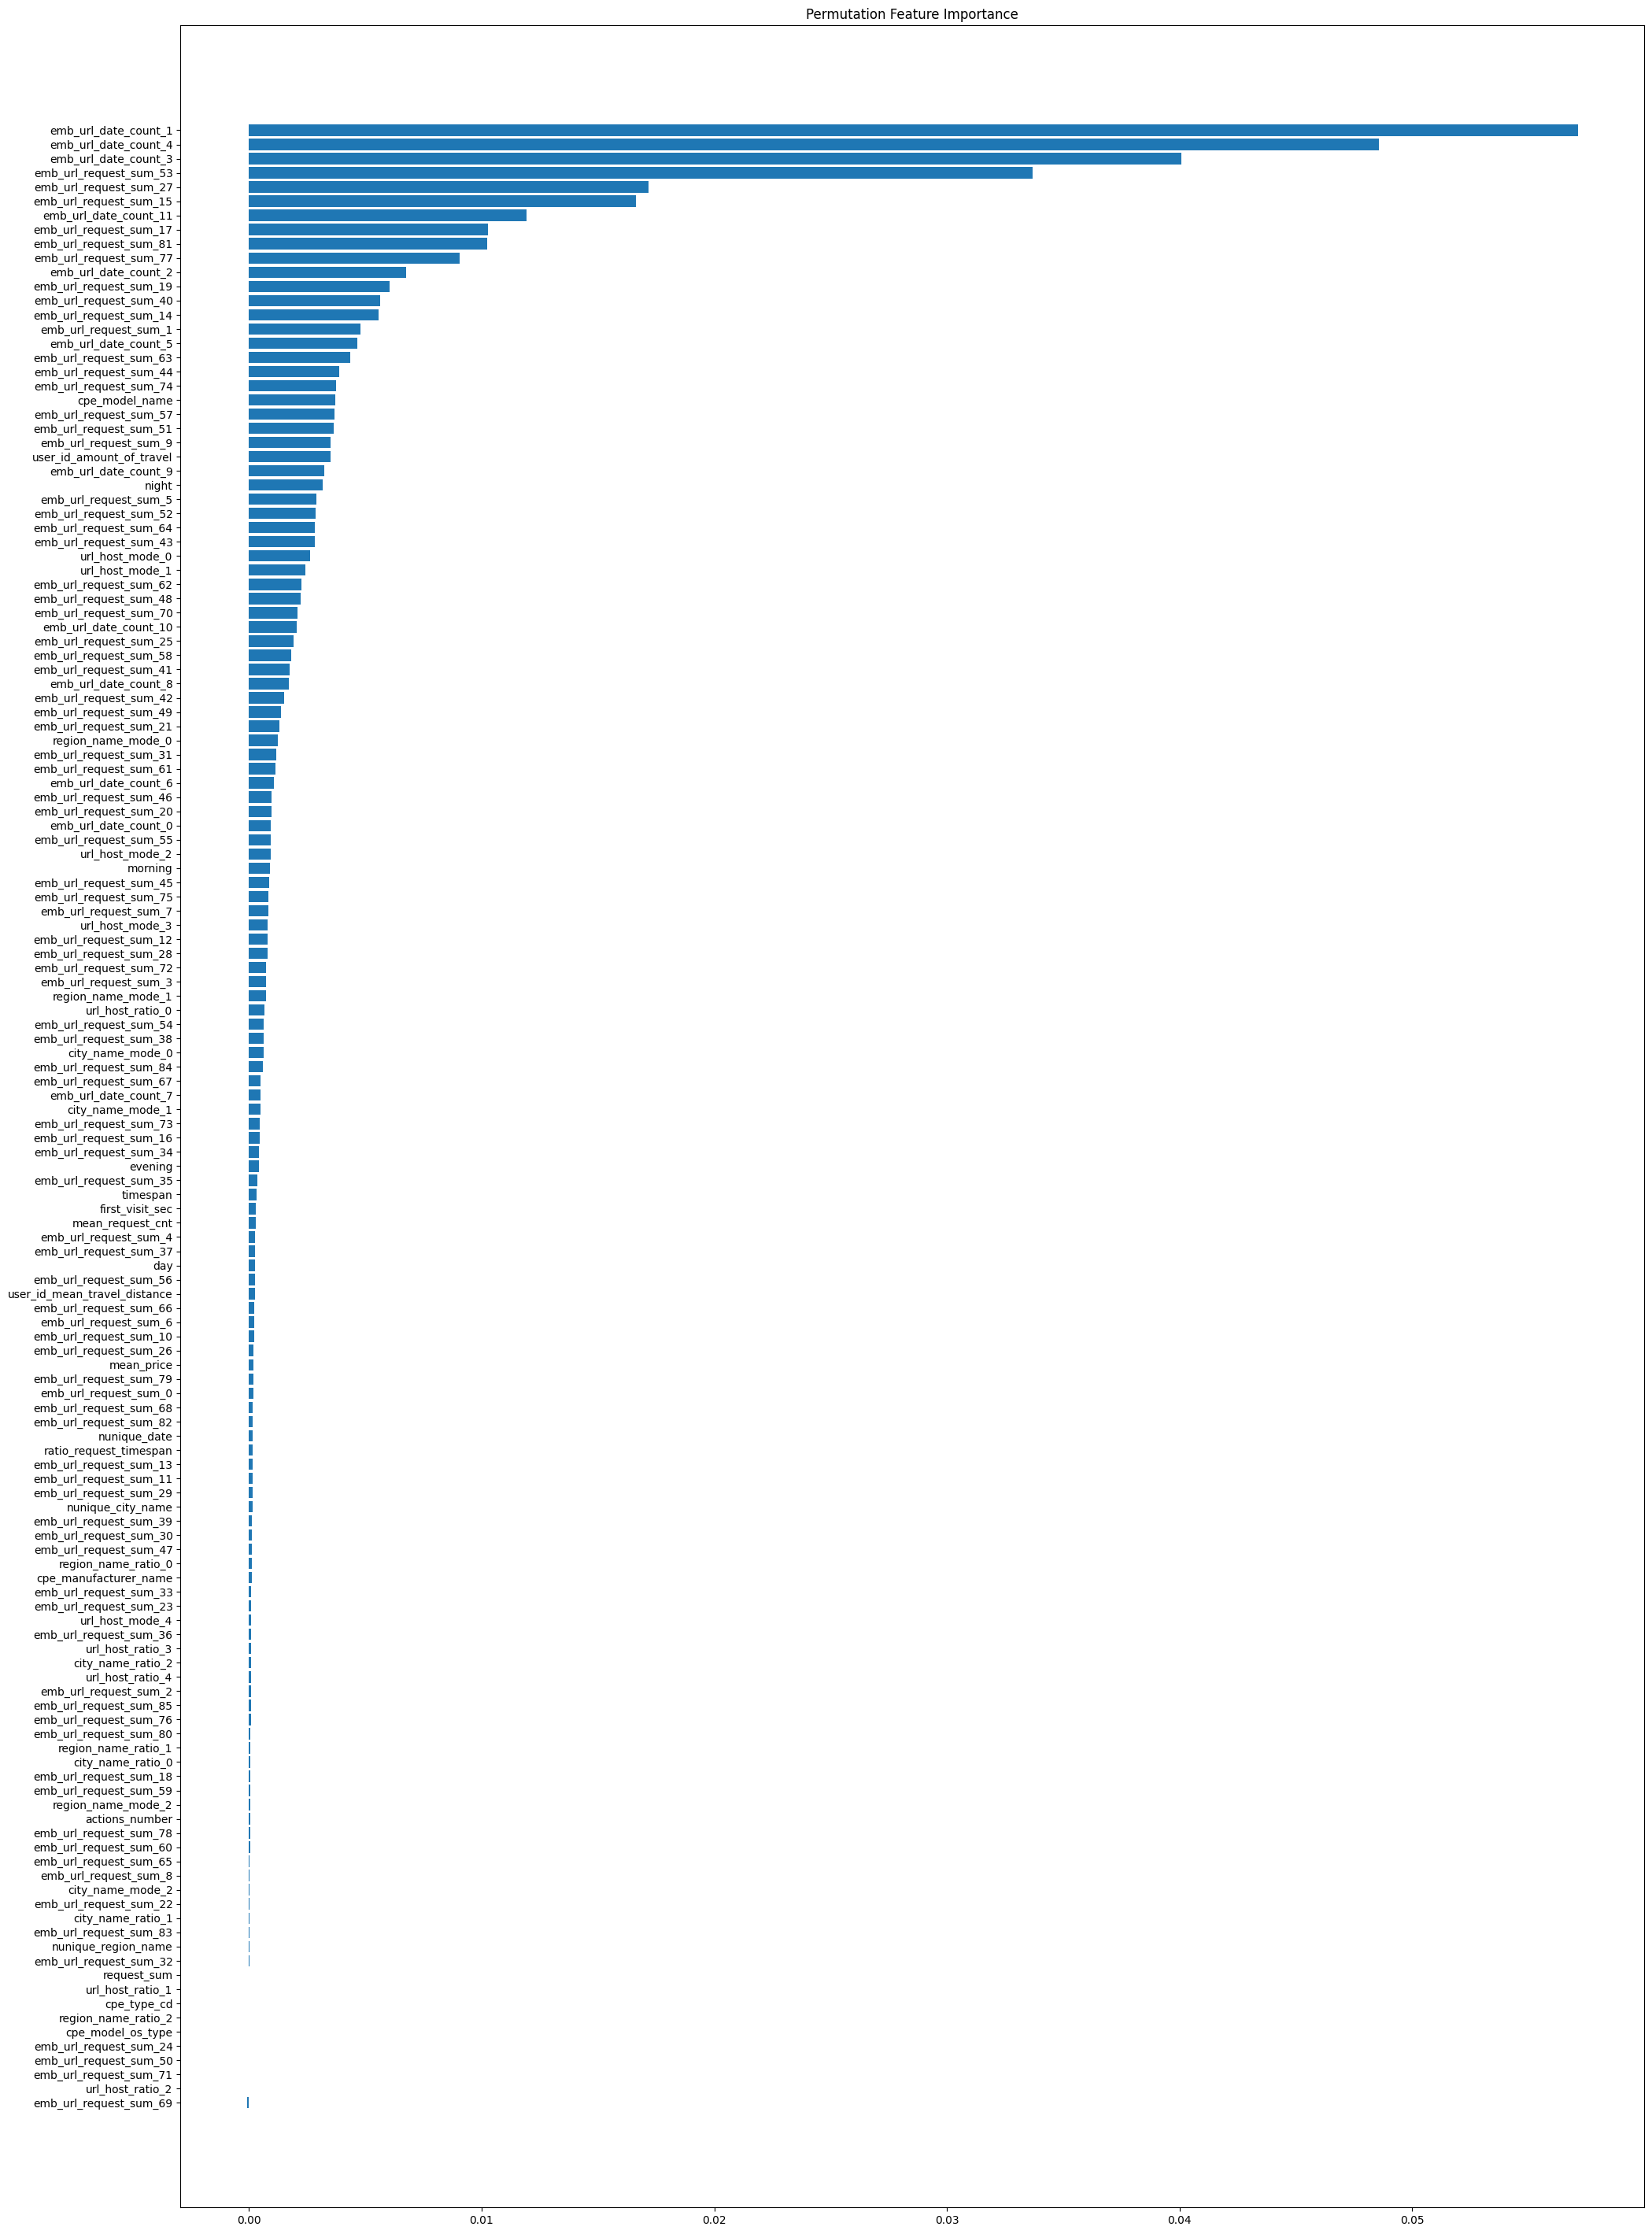

In [66]:
feature_importance = is_male_importances["Importance"].to_numpy()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(24, 36))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), is_male_importances["Feature Id"].to_numpy()[sorted_idx])
plt.title('Permutation Feature Importance')

# Predict

In [26]:
from catboost import Pool
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

from tqdm.auto import tqdm

In [27]:
FE_DATA = "../fe_data/"
userfe = UserFE()
userfe.load(path=f"{FE_DATA}/USER_FE.parquet.gzip")
userfe.df

Memory usage of dataframe is 282.01 MB


  0%|          | 0/143 [00:00<?, ?it/s]

Memory usage after optimization is: 282.01 MB
Decreased by 0.0%


,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,user_id,age,is_male,mean_price,actions_number,nunique_date,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
0,Apple,iPhone 7,smartphone,iOS,45098,NaN,NaN,20368.0,1550,117,...,-0.487459,-0.451297,0.205221,0.365753,-0.038074,-0.371062,-0.347951,-1.124802,1.116378,-0.605543
1,Xiaomi,Redmi 5 Plus,smartphone,Android,117132,NaN,NaN,4990.0,722,32,...,-0.476611,0.130673,0.132837,0.025192,-0.379870,-0.384682,-0.486816,-0.743641,0.278062,-0.606177
2,Samsung,Galaxy S20+,smartphone,Android,79395,35.0,1.0,74259.0,1635,51,...,-0.555467,-0.148673,0.490465,-0.395534,0.551452,-0.641597,0.235146,-1.390079,0.221776,-0.589873
3,Xiaomi,Poco X3 Pro,smartphone,Android,91294,35.0,1.0,23876.0,1570,113,...,-0.825914,-0.017051,0.723013,0.193677,0.929095,-1.063128,0.400775,-1.512914,0.562912,-0.608336
4,Xiaomi,Redmi Note 8 Pro,smartphone,Android,161323,39.0,0.0,20465.0,313,15,...,-0.339168,0.046154,0.644329,0.137939,-0.429767,-1.130276,-0.069693,-1.260576,0.236189,-0.598482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,Apple,iPhone X,smartphone,iOS,375972,48.0,0.0,56357.0,690,61,...,-0.367244,-0.221943,-0.024665,0.066285,-0.320592,-0.569684,-0.632674,-1.020382,0.607768,-0.268611
415313,Apple,iPhone 7,smartphone,iOS,160996,NaN,NaN,26154.0,460,23,...,-0.388560,-0.080856,0.157780,0.331962,-0.134558,-0.337920,-0.589342,-0.975730,0.333884,0.006961
415314,Huawei,P Smart Z,smartphone,Android,5505,26.0,1.0,15490.0,96,11,...,-0.312762,-0.006308,0.661723,0.378763,-0.299067,-0.438742,-0.275950,-0.060483,0.209070,-0.446256
415315,Apple,iPhone SE 2020,smartphone,iOS,260127,NaN,NaN,40612.0,860,27,...,-0.214815,0.144838,0.386581,0.309508,-0.513405,-0.109134,-0.485071,-1.433589,1.055682,-0.613989


In [28]:
LOCAL_DATA = "../data"

needed_ids = pandas_reduce_mem_usage( 
        pd.read_parquet(f'{LOCAL_DATA}/submit_2.pqt')
) 
needed_ids.head()

Memory usage of dataframe is 2.21 MB


  0%|          | 0/1 [00:00<?, ?it/s]

Memory usage after optimization is: 1.66 MB
Decreased by 25.0%


,user_id
221301,221301
31271,31271
211594,211594
253119,253119
192578,192578


In [29]:
test = needed_ids.merge(userfe.df.drop(columns=["age", "is_male"]), on="user_id", how="left")
test.head()

,user_id,cpe_manufacturer_name,cpe_model_name,cpe_type_cd,cpe_model_os_type,mean_price,actions_number,nunique_date,request_sum,url_host_mode_0,...,emb_url_date_count_2,emb_url_date_count_3,emb_url_date_count_4,emb_url_date_count_5,emb_url_date_count_6,emb_url_date_count_7,emb_url_date_count_8,emb_url_date_count_9,emb_url_date_count_10,emb_url_date_count_11
0,221301,Apple,iPhone SE,smartphone,iOS,14381.0,564,19,1192,instagram.com,...,-0.477768,-0.304121,0.281711,0.437949,-0.379156,-0.277914,-0.473263,-0.902318,0.662917,-0.497679
1,31271,Samsung,Galaxy A30 Dual,smartphone,Android,12636.0,4,1,10,yandex.ru,...,-0.077670,0.001416,0.290030,0.140780,-0.076636,-0.105728,-0.127635,0.096999,0.075125,-0.063195
2,211594,Xiaomi,Poco X3 Pro,smartphone,Android,23876.0,4,2,7,unblock.mts.ru,...,-0.078477,0.027607,0.186699,-0.009173,-0.037037,-0.017283,-0.128097,0.102028,0.084676,-0.047032
3,253119,Xiaomi,Redmi 9,smartphone,Android,13133.0,14,2,16,i.ytimg.com,...,-0.162264,0.003588,0.537526,0.285017,-0.186246,-0.246277,-0.273464,0.098354,0.160195,-0.181369
4,192578,Apple,iPhone 7,smartphone,iOS,42009.0,143,6,216,apple.com,...,-0.315334,-0.048776,0.668127,0.383950,-0.368453,-0.325255,-0.687155,-0.386749,0.482435,-0.204027


In [31]:
is_male_embeddings_df = pd.read_parquet(f"../test_is_male_logits.parquet.gzip").drop(columns=["target_feature_0"])
age_embeddings_df = pd.read_parquet(f"../test_age_logits.parquet.gzip")

is_male_embeddings_df.head()

,target_feature_1,user_id
0,0.450140,6
1,0.671860,7
2,0.456391,9
3,0.286317,10
4,0.742313,11


In [32]:
age_embeddings_df.head()

,target_feature_0,target_feature_1,target_feature_2,target_feature_3,target_feature_4,target_feature_5,user_id
0,0.033956,0.136560,0.266697,0.280620,0.183845,0.098323,6
1,0.015066,0.072248,0.198331,0.340407,0.269000,0.104947,7
2,0.008553,0.051414,0.172918,0.328595,0.292672,0.145848,9
3,0.013551,0.097607,0.264784,0.341348,0.201563,0.081146,10
4,0.033808,0.141548,0.273851,0.282155,0.176864,0.091774,11


In [33]:
age_test = test.merge(age_embeddings_df, on="user_id", how="left")
is_male_test = test.merge(is_male_embeddings_df, on="user_id", how="left")

age_test.isnull().sum().sum(), is_male_test.isnull().sum().sum()

(0, 0)

In [34]:
(age_test["user_id"] == is_male_test["user_id"]).sum() / is_male_test.shape[0]

1.0

In [35]:
age_X_test = age_test.drop(columns=["user_id"])
is_male_X_test = is_male_test.drop(columns=["user_id"])

In [36]:
def cross_val_predict(model_folder, df, drop_columns=None):
    if drop_columns: 
        df = df.drop(columns=drop_columns)
        print("YEAAAAAAAAAAH BITCH")
        
    test_pool = Pool(df, cat_features=np.where(df.dtypes == object)[0])
    
    model_names = os.listdir(model_folder)
    
    preds = []
    
    for model_name in tqdm(model_names):
        model = CatBoostClassifier().load_model(f"{model_folder}/{model_name}")
        pred = model.predict_proba(test_pool)
        
        preds.append(pred)
    
    return sum(preds) / len(preds)

In [37]:
age_preds = cross_val_predict("../catboost_models/age_v2", age_X_test, drop_columns=age_kicked).argmax(axis=1) + 1
needed_ids["age"] = age_preds

age_preds

YEAAAAAAAAAAH BITCH


  0%|          | 0/5 [00:00<?, ?it/s]

array([2, 3, 2, ..., 3, 2, 3])

In [38]:
is_male_preds = cross_val_predict("../catboost_models/is_male_v2", is_male_X_test, drop_columns=is_male_kicked)[:, 1]
needed_ids["is_male"] = is_male_preds

is_male_preds

YEAAAAAAAAAAH BITCH


  0%|          | 0/5 [00:00<?, ?it/s]

array([0.84585252, 0.52471032, 0.51344764, ..., 0.5082907 , 0.62324884,
       0.45342701])

In [39]:
needed_ids

,user_id,age,is_male
221301,221301,2,0.845853
31271,31271,3,0.524710
211594,211594,2,0.513448
253119,253119,2,0.647268
192578,192578,2,0.828737
...,...,...,...
145307,415284,2,0.450852
145308,415285,2,0.542198
145309,415286,3,0.508291
145312,415306,2,0.623249


In [43]:
needed_ids.to_csv("catboost_with_seq2seq_v3.csv", index=False)